In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../../")
import data_loading as dl
from importlib import reload
reload(dl)

from microfit import run_plotter as rp
from microfit import histogram as hist

from microfit import variable_definitions as vdef
from microfit import selections

In [ ]:
RUN = ["3"]
#RUN = ["1","2","3"] #important that it's a string 1) new format to include latest runs 2) to include 'mc_pdg' otherwise it gets dropped

rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",
    loadpi0variables=False,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
#    load_lee=True,
    blinded=True,
    enable_cache=True,
)


In [7]:
print(rundata.keys())
#from particle import Particle
print("mc_pz" in rundata["mc"].columns)

dict_keys(['data', 'ext', 'mc', 'nue', 'drt'])
True


In [3]:
import uproot

fold = "nuselection"
tree = "NeutrinoSelectionFilter"
path = "/uboone/data/users/cthorpe/PELEE_2023_Samples/"
RUN1 = "run1/nuepresel/"
RUN2 = "run2/nuepresel/"
RUN3 = "run3/nuepresel/"
RUN4 = "run4/nuepresel/"
RUN5 = "run5/nuepresel/"
fn = "overlay_peleeTuple_uboone_v08_00_00_70_run3_nu.root"

data_path = path + RUN3 + fn

#df = uproot.open('/pnfs/uboone/persistent/users/jdetje/pelee_v08_00_00_70/overlay_peleeTuple_uboone_v08_00_00_70_run3_nu.root')[fold][tree].pandas.df(flatten=False)
variables = ['mc_pdg', 'mc_E', 'mc_px', 'mc_py', 'mc_pz', 'nu_pdg', 'category', 'true_nu_vtx_x', 'true_nu_vtx_y', 'true_nu_vtx_z']

up = uproot.open('/pnfs/uboone/persistent/users/jdetje/pelee_v08_00_00_70/overlay_peleeTuple_uboone_v08_00_00_70_run3_nu.root')[fold][tree]
df = up.pandas.df(variables, flatten=False)

In [4]:
################################################################################
# Check there is a final state muon above threshold, and return its index

muon_p_min = 0.1
muon_p_max = 1.2
muon_mass = 0.1057
muon_E_min = np.sqrt(muon_p_min**2 + muon_mass**2)
muon_E_max = np.sqrt(muon_p_max**2 + muon_mass**2) # SG's code imposes an upper limit

def true_muon_idx(mc_pdg,mc_E):

    for i in range(0,len(mc_pdg)):
        if abs(mc_pdg[i]) == 13 and muon_E_min < mc_E[i] < muon_E_max:
            return i

    return -1

################################################################################
# Check there is a final state electron above threshold, and return its index

elec_p_min = 0. #GeV
elec_p_max = 5.0 #GeV
elec_mass = 0.511e-3 #GeV
elec_E_min = np.sqrt(elec_p_min**2 + elec_mass**2)
elec_E_max = np.sqrt(elec_p_max**2 + elec_mass**2) # Upper limit currently unused

def true_elec_idx(mc_pdg,mc_E):

    for i in range(0,len(mc_pdg)):
        if abs(mc_pdg[i]) == 11 and mc_E[i] > elec_E_min:
        #if abs(mc_pdg[i]) == 11 and elec_E_min < mc_E[i] < elec_E_max:
            return i

    return -1

################################################################################
# Final state has one proton above threshold

proton_p_min = 0.300 #GeV
proton_p_max = 3.0
proton_mass = 0.939
proton_E_min = np.sqrt(proton_p_min**2 + proton_mass**2)
proton_E_max = np.sqrt(proton_p_max**2 + proton_mass**2) # Upper limit currently unused

def true_proton_idx(mc_pdg,mc_E):

    idx = []
    for i in range(0,len(mc_pdg)):
        if abs(mc_pdg[i]) == 2212 and mc_E[i] > proton_E_min:
        #if abs(mc_pdg[i]) == 2212 and proton_E_min < mc_E[i] < proton_E_max:
            idx.append(i)

    return idx

################################################################################
# Number of protons above threshold

def n_proton(TrueIdx_v):

    return len(TrueIdx_v) 

################################################################################
# Index of lead proton 

def true_lead_proton_idx(mc_pdg,mc_E):

    lead_idx = -1
    lead_E = -1
    for i in range(0,len(mc_pdg)):
        if abs(mc_pdg[i]) == 2212 and mc_E[i] > proton_E_min and mc_E[i] > lead_E:
        #if abs(mc_pdg[i]) == 2212 and proton_E_min < mc_E[i] < proton_E_max and mc_E[i] > lead_E:
            lead_E = mc_E[i]
            lead_idx = i

    return lead_idx

################################################################################
# Final state has no charged pions above thresold and no pi0

pion_thresh = 0.07 #GeV
pion_mass = 0.1396
pion_E_thresh = np.sqrt(pion_thresh**2 + pion_mass**2)

def has_no_mesons(mc_pdg,mc_E):
    for i in range(0,len(mc_pdg)):
        if (abs(mc_pdg[i]) == 211 and mc_E[i] > pion_E_thresh) or mc_pdg[i] == 111 or abs(mc_pdg[i]) == 321:
            return False 

    return True

################################################################################
# Number of charged pions above threshold

def n_fs_pion(mc_pdg,mc_E):

    n_pion = 0
    for i in range(0,len(mc_pdg)):
        if abs(mc_pdg[i]) == 211 and mc_E[i] > pion_E_thresh:
            n_pion += 1

    return n_pion

################################################################################
# Number of neutral pions

def n_fs_pi0(mc_pdg,mc_E):

    n_pi0 = 0
    for i in range(0,len(mc_pdg)):
        if mc_pdg[i] == 111:
            n_pi0 += 1

    return n_pi0

################################################################################
# True primary vertex is in the fiducial volume

# Definitions in PeLEE technote and 'selected' variable
# https://github.com/ubneutrinos/searchingfornues/blob/0489ac5457335a553a3bab54ee5d7ba91734adf0/Selection/SelectionTools/CC0piNpSelection_tool.cc#L97-L102
# https://github.com/ubneutrinos/searchingfornues/blob/889002e5ec93b567265c3af8c178172363200490/Selection/SelectionTools/CC0piNpSelection_tool.cc#L415-L420
FV_X_MIN =   10.0
FV_X_MAX =  246.4
FV_Y_MIN = -101.5
FV_Y_MAX =  101.5
FV_Z_MIN =   10.0
FV_Z_MAX =  986.8
DEAD_Z_MIN = 675 # SG's code does not cut dead region 
DEAD_Z_MAX = 775

def in_fiducial_volume(true_nu_vtx_x,true_nu_vtx_y,true_nu_vtx_z):

    return FV_X_MIN < true_nu_vtx_x < FV_X_MAX and\
           FV_Y_MIN < true_nu_vtx_y < FV_Y_MAX and\
           FV_Z_MIN < true_nu_vtx_z < FV_Z_MAX and\
           not (DEAD_Z_MIN < true_nu_vtx_z < DEAD_Z_MAX)

################################################################################
# Component of the momentum of a particle at index TrueIdx

def true_mom(TrueIdx,mc_p):

    if TrueIdx == -1:
        return np.nan
    else:
        return mc_p[TrueIdx]
    
################################################################################
# Component of the total momentum of a group of particles 

def true_mom_tot(TrueIdx_v,mc_p):

    if len(TrueIdx_v) == 0:
        return np.nan

    p = 0
    for i in TrueIdx_v:
        p = p + mc_p[i]    

    return p 

################################################################################
# Vector of momenta of group of particles 

def true_mom_v(TrueIdx_v,mc_p):

    p = np.array([])
    for i in TrueIdx_v:
        p = np.append(p, mc_p[i])

    return p 


In [5]:
################################################################################
# Add a column indicating if the events belong to the 1e1p signal
# Add a column to define the topological categories for analysis (based on the 'category' variable)

def set_Signal1e1p(up,df):

    # Load the extra branches needed 
    df["mc_pdg"] = up.array("mc_pdg")
    df["mc_E"] = up.array("mc_E")
    df["mc_px"] = up.array("mc_px")
    df["mc_py"] = up.array("mc_py")
    df["mc_pz"] = up.array("mc_pz")

    df["InFV"] = df.apply(lambda x: (in_fiducial_volume(x["true_nu_vtx_x"],x["true_nu_vtx_y"],x["true_nu_vtx_z"])),axis=1)
    
    df["TrueMuonIdx"] = df.apply(lambda x: (true_muon_idx(x["mc_pdg"],x["mc_E"])),axis=1)
    df["TrueElecIdx"] = df.apply(lambda x: (true_elec_idx(x["mc_pdg"],x["mc_E"])),axis=1)
    df["TrueLeadProtonIdx"] = df.apply(lambda x: (true_lead_proton_idx(x["mc_pdg"],x["mc_E"])),axis=1)
    
    df["TrueProtonIdx"] = df.apply(lambda x: (true_proton_idx(x["mc_pdg"],x["mc_E"])),axis=1)
    df["TrueNProt"] = df.apply(lambda x: (n_proton(x["TrueProtonIdx"])),axis=1)
    df["TrueFSPions"] = df.apply(lambda x: (n_fs_pion(x["mc_pdg"],x["mc_E"])),axis=1)
    df["TrueFSPi0"] = df.apply(lambda x: (n_fs_pi0(x["mc_pdg"],x["mc_E"])),axis=1)
    df["HasNoMesons"] = df.apply(lambda x: (has_no_mesons(x["mc_pdg"],x["mc_E"])),axis=1)
    
    # Set the signal definition
    nue_cc0piNp = ((abs(df["nu_pdg"]) == 12) & (df["TrueElecIdx"] != -1) & (df["TrueLeadProtonIdx"] != -1) & (df["InFV"] == True) & (df["HasNoMesons"] == True))
    nue_cc0pi1p = ((abs(df["nu_pdg"]) == 12) & (df["TrueElecIdx"] != -1) & (df["TrueLeadProtonIdx"] != -1) & (df["InFV"] == True) & (df["HasNoMesons"] == True) & (df["TrueNProt"] == 1))
    
#     df.loc[nue_cc0piNp, "Signal_1eNp"] = True
#     df.loc[~nue_cc0piNp, "Signal_1eNp"] = False
    
    df.loc[nue_cc0pi1p, "Signal_1e1p"] = True
    df.loc[~nue_cc0pi1p, "Signal_1e1p"] = False
    
    # Set the topological categories
    
    nue_cc0pi0p = ((abs(df["nu_pdg"]) == 12) & (df["TrueElecIdx"] != -1) & (df["TrueLeadProtonIdx"] == -1) & (df["InFV"] == True) & (df["HasNoMesons"] == True) & (df["TrueNProt"] == 0))
    nue_cc0pi2p = ((abs(df["nu_pdg"]) == 12) & (df["TrueElecIdx"] != -1) & (df["TrueLeadProtonIdx"] != -1) & (df["InFV"] == True) & (df["HasNoMesons"] == True) & (df["TrueNProt"] >= 2))
    nue_cc = ((abs(df["nu_pdg"]) == 12) & (df["TrueElecIdx"] != -1) & (df["InFV"] == True) & (df["TrueFSPions"] > 0) & (df["TrueFSPi0"] > 0) & (df["TrueNProt"] >= 0))
    #nue_cc = ((abs(df["nu_pdg"]) == 12) & (df["TrueElecIdx"] != -1) & (df["InFV"] == True) & (df["HasNoMesons"] == False) & (df["TrueNProt"] >= 0))
    nue_nc0pi0 = ((abs(df["nu_pdg"]) == 12) & (df["TrueElecIdx"] == -1) & (df["InFV"] == True) & (df["TrueFSPions"] == 0) & (df["TrueFSPi0"] == 0) & (df["TrueNProt"] == 0))
    nue_ncNpi0 = ((abs(df["nu_pdg"]) == 12) & (df["TrueElecIdx"] == -1) & (df["InFV"] == True) & (df["TrueFSPions"] == 0) & (df["TrueFSPi0"] >= 1) & (df["TrueNProt"] == 0))
    
    numu_ccNpi0 = ((abs(df["nu_pdg"]) == 14) & (df["TrueMuonIdx"] != -1) & (df["InFV"] == True) & (df["TrueFSPions"] >= 0) & (df["TrueFSPi0"] >= 1) & (df["TrueNProt"] >= 0))
    numu_cc0pi0 = ((abs(df["nu_pdg"]) == 14) & (df["TrueMuonIdx"] != -1) & (df["InFV"] == True) & (df["TrueFSPions"] >= 0) & (df["TrueFSPi0"] == 1) & (df["TrueNProt"] >= 0))
    numu_nc0pi0 = ((abs(df["nu_pdg"]) == 14) & (df["TrueMuonIdx"] == -1) & (df["InFV"] == True) & (df["TrueFSPions"] == 0) & (df["TrueFSPi0"] == 0) & (df["TrueNProt"] == 0))
    numu_ncNpi0 = ((abs(df["nu_pdg"]) == 14) & (df["TrueMuonIdx"] == -1) & (df["InFV"] == True) & (df["TrueFSPions"] == 0) & (df["TrueFSPi0"] >= 1) & (df["TrueNProt"] == 0))
    
    outFV = df["InFV"] == False
    #cosmic = ((abs(df["nu_pdg"]) != 14) & (df["nu_pdg"] != 12) & (df["InFV"] == True))
    cosmic = ((df["InFV"] == True) & ~nue_cc0piNp & ~nue_cc0pi1p & ~nue_cc0pi0p & ~nue_cc0pi2p & ~nue_cc & ~nue_nc0pi0 & ~nue_ncNpi0 & ~numu_ccNpi0 & ~numu_cc0pi0 & ~numu_nc0pi0 & ~numu_ncNpi0)
    
    df["test"] = 6
    df.loc[nue_cc0pi0p, "test"] = 10
    df.loc[nue_cc0pi1p, "test"] = 12
    df.loc[nue_cc0pi2p, "test"] = 13
    df.loc[nue_cc, "test"] = 1
    df.loc[nue_nc0pi0, "test"] = 3
    df.loc[nue_ncNpi0, "test"] = 31
    df.loc[numu_cc0pi0, "test"] = 2
    df.loc[numu_ccNpi0, "test"] = 21
    df.loc[numu_nc0pi0, "test"] = 3
    df.loc[numu_ncNpi0, "test"] = 31
    df.loc[outFV, "test"] = 5
    df.loc[cosmic, "test"] = 4
    
    df["category_1e1p_tki"] = 6  # 'other'
    df.loc[nue_cc0pi0p, "category_1e1p_tki"] = 10
    df.loc[nue_cc0pi1p, "category_1e1p_tki"] = 12  # 1e1p signal
    df.loc[nue_cc0pi2p, "category_1e1p_tki"] = 13
    df.loc[nue_cc, "category_1e1p_tki"] = 1
    df.loc[nue_nc0pi0, "category_1e1p_tki"] = 3
    df.loc[nue_ncNpi0, "category_1e1p_tki"] = 31
    df.loc[numu_cc0pi0, "category_1e1p_tki"] = 2
    df.loc[numu_ccNpi0, "category_1e1p_tki"] = 21
    df.loc[numu_nc0pi0, "category_1e1p_tki"] = 3
    df.loc[numu_ncNpi0, "category_1e1p_tki"] = 31
    df.loc[outFV, "category_1e1p_tki"] = 5
    df.loc[cosmic, "category_1e1p_tki"] = 4
    
    
    # Drop temporary data from dataframes
    df.drop("mc_pdg",inplace=True,axis=1)
    df.drop("mc_E",inplace=True,axis=1)
    df.drop("mc_px",inplace=True,axis=1)
    df.drop("mc_py",inplace=True,axis=1)
    df.drop("mc_pz",inplace=True,axis=1)
    
    return df

In [6]:
#df = up.pandas.df(variables, flatten=False)
run3mc = set_Signal1e1p(up,df)
run3mc.loc[:, ('Signal_1e1p', 'category_1e1p_tki')].head(20)

,Signal_1e1p,category_1e1p_tki
entry,,
0,False,5
1,False,4
2,False,5
3,False,21
4,False,4
5,False,5
6,False,5
7,False,5
8,False,5


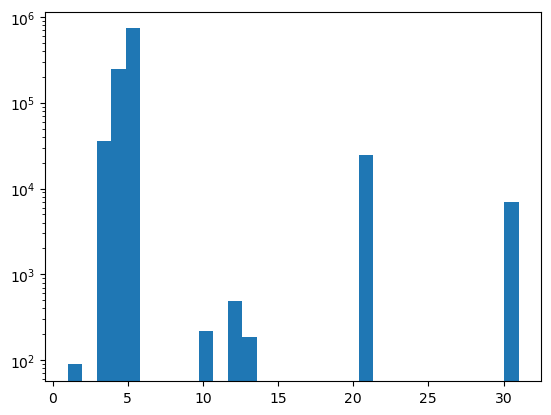

In [7]:
plt.hist(run3mc['category_1e1p_tki'], 31)
plt.yscale('log')

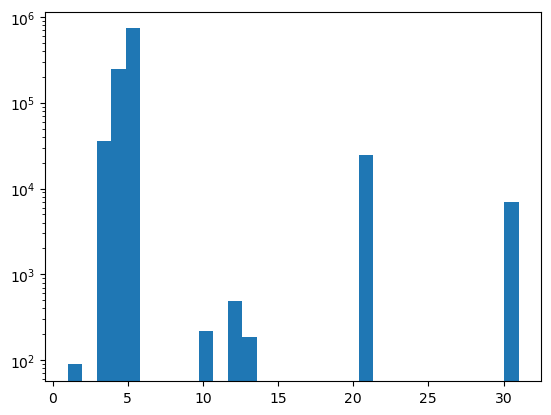

In [8]:
plt.hist(run3mc['test'], 31)
plt.yscale('log')

In [9]:
is_sig = run3mc['Signal_1e1p'] == True
all_sig = run3mc.loc[is_sig]

top_sig = run3mc['category_1e1p_tki'] == 12
all_top_sig = run3mc.loc[top_sig]

test_sig = run3mc['test'] == 12
all_test_sig = run3mc.loc[test_sig]

print('Signal_1e1p:', len(all_sig))
print('category_1e1p_tki:', len(all_top_sig))
print('test:', len(all_test_sig))
print(len(run3mc))

Signal_1e1p: 485
category_1e1p_tki: 485
test: 485
1047989


In [ ]:
category_labels_1e1p = {
#     1: r"$\nu_e$ CC",
#     10: r"$\nu_e$ CC0$\pi$0p",
#     # 11: r"$\nu_e$ CC0$\pi$Np",
#     12: r"$\nu_e$ CC0$\pi$1p",
#     13: r"$\nu_e$ CC0$\pi$2+p",
    111: r"MiniBooNE LEE",
#     2: r"$\nu_{\mu}$ CC",
    222: r"$\nu_{\mu}$ CC w/ Michel",
#     21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p",
    23: r"$\nu_{\mu}$ CC 1p",
    24: r"$\nu_{\mu}$ CC 2p",
    25: r"$\nu_{\mu}$ CC 3+p",
#     3: r"$\nu$ NC",
#     31: r"$\nu$ NC $\pi^{0}$",
#     4: r"Cosmic",
#     5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r"1 $\pi^0$",
    804: r"2 $\pi^0$",
    807: r"3+ $\pi^0$",
    805: r"$\nu$ other",
    806: r"out of FV",
    6: r"other",
    0: r"No slice",
}

In [22]:
# Investigating how the 'selected' variable is defined wrt FV

all_mc = pd.concat([df for k, df in rundata.items() if k!='data'])
filtered = all_mc.query('selected == 1') #, inplace=True)

vertices = ['reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z']

for vtx in vertices:
    fig, ax = plt.subplots()
    ax.hist(all_mc[vtx], histtype='step', label='All MC')
    ax.hist(filtered[vtx], histtype='step', label='selected = 1')
    ax.legend()
    ax.set_xlabel(f'{vtx}')
    text = f"All MC Min vertex: {all_mc[vtx].min():.4f} \n Filtered Min vertex: {filtered[vtx].min():.4f} \n \n All MC Max vertex: {all_mc[vtx].max():.4f} \n Filtered Max vertex: {filtered[vtx].max():.4f}"
    ax.text(0.5, 0.5, text, ha="center", va="center", transform=ax.transAxes, fontsize=10, bbox=dict(facecolor="white", edgecolor="none", alpha=0.8))
    plt.savefig(f'plots/investigation/Run123_{vtx}.pdf', bbox_inches='tight')
    plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
all_mc = pd.concat([df for k, df in rundata.items() if k!='data' or k!='ext'])

In [17]:
rundata['mc']['test'] = 6
rundata['mc'].loc[(rundata['mc']['interaction'] == 1), 'test'] = 1
rundata['mc'].loc[:, ('interaction', 'test')].head(60)

,interaction,test
entry,,
0,2,6
1,2,6
2,2,6
3,2,6
4,2,6
5,1,1
7,2,6
8,1,1
9,1,1


In [ ]:
from microfit import selections as sel

#print(sel.selection_categories)

selection = "OnePL"
preselection = "OneP"
query = f"{sel.preselection_categories[preselection]['query']} and {sel.selection_categories[selection]['query']}"
#print(query)

all_mc = pd.concat([df for k, df in rundata.items() if k!='data'])
#is_sig = all_mc['category_1e1p_tki'] == 12
is_sig = all_mc['Signal_1e1p'] == True
all_sig = all_mc.loc[is_sig]
sel_sig = all_sig.query(query, engine='python')

print(len(all_sig))
print()

all_mc.loc[all_mc['category_1e1p_tki'] == 6].head()
print(len(all_mc))
print(len(all_mc.loc[all_mc['category_1e1p_tki'] == 6]))
plt.hist(all_mc['category_1e1p_tki'], 31)